In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm, multivariate_normal
from scipy.special import expit
from pypolyagamma import PyPolyaGamma

from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_random_state, shuffle as _shuffle

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hvcowt81 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
num_index_points = 512
num_features = 1
num_samples = 32
num_train = 100

seed = 8888
random_state = np.random.RandomState(seed)

x_min, x_max = -5.0, 5.0

X_grid = np.linspace(x_min, x_max, num_index_points).reshape(-1, num_features)

In [3]:
p = norm(loc=1.0, scale=1.0)
q = norm(loc=0.0, scale=2.0)

In [4]:
def logit(x):

    return p.logpdf(x) - q.logpdf(x)

In [5]:
def density_ratio(x):

    return np.exp(logit(x))

In [6]:
def class_probability(x):

    return expit(logit(x))

In [7]:
def make_dataset(num_samples, rate=0.5, random_state=None):

    num_top = int(num_samples * rate)
    num_bot = num_samples - num_top

    X_top = p.rvs(size=num_top, random_state=random_state)
    X_bot = q.rvs(size=num_bot, random_state=random_state)

    return X_top, X_bot

In [8]:
def make_classification_dataset(X_pos, X_neg, shuffle=False, dtype="float64",
                                random_state=None):

    X = np.vstack([X_pos.reshape(-1, 1), X_neg.reshape(-1, 1)]).astype(dtype)
    y = np.hstack([np.ones_like(X_pos), np.zeros_like(X_neg)])

    if shuffle:
        X, y = _shuffle(X, y, random_state=random_state)

    return X, y


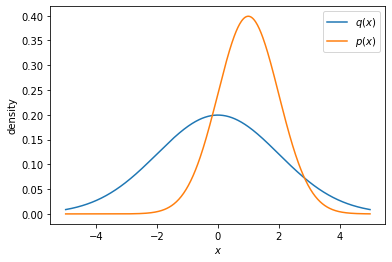

In [9]:
fig, ax = plt.subplots()

ax.plot(X_grid, q.pdf(X_grid), label='$q(x)$')
ax.plot(X_grid, p.pdf(X_grid), label='$p(x)$')

ax.set_xlabel('$x$')
ax.set_ylabel('density')

ax.legend()

plt.show()

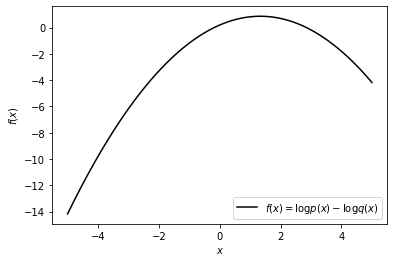

In [10]:
fig, ax = plt.subplots()

ax.plot(X_grid, logit(X_grid), c='k', label=r"$f(x) = \log p(x) - \log q(x)$")

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

ax.legend()

plt.show()

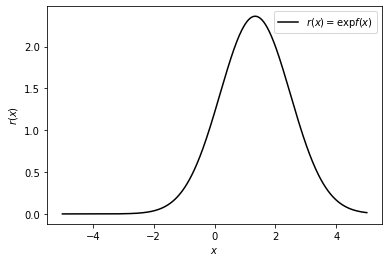

In [11]:
fig, ax = plt.subplots()

ax.plot(X_grid, density_ratio(X_grid), c='k', label=r"$r(x) = \exp f(x)$")

ax.set_xlabel('$x$')
ax.set_ylabel('$r(x)$')

ax.legend()

plt.show()

In [12]:
X_p, X_q = make_dataset(num_train, rate=0.5, random_state=seed)
X_train, y_train = make_classification_dataset(X_p, X_q)

In [13]:
y_train.shape

(100,)

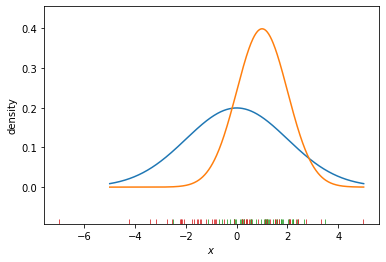

In [14]:
fig, ax = plt.subplots()

ax.plot(X_grid, q.pdf(X_grid), label='$q(x)$')
ax.plot(X_grid, p.pdf(X_grid), label='$p(x)$')

sns.rugplot(X_p.squeeze(), height=0.02, alpha=0.8, ax=ax)
sns.rugplot(X_q.squeeze(), height=0.02, alpha=0.8, ax=ax)

ax.set_xlabel('$x$')
ax.set_ylabel('density')

plt.show()

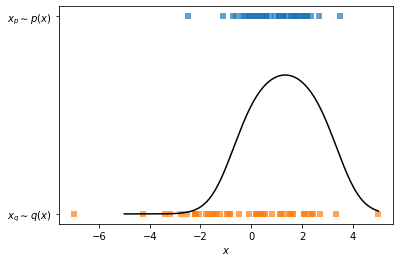

In [15]:
fig, ax = plt.subplots()

ax.scatter(X_p, np.ones_like(X_p), marker='s',
           edgecolors="none", alpha=0.7, zorder=2)
ax.scatter(X_q, np.zeros_like(X_q), marker='s',
           edgecolors="none", alpha=0.7, zorder=2)

ax.plot(X_grid, class_probability(X_grid), c='k', label=r"$\pi(x) = \sigma(f(x))$")

ax.set_yticks([0, 1])
ax.set_yticklabels([r"$x_q \sim q(x)$", r"$x_p \sim p(x)$"])
ax.set_xlabel('$x$')

plt.show()

In [16]:
def basis_function(x, degree=3):

#     return np.hstack([np.ones_like(X), X])
#     return np.hstack([np.ones_like(X), X, X**2, X**3])

    return np.power(x, np.arange(degree))

In [17]:
Phi = basis_function(X_train)
Phi.shape

(100, 3)

In [18]:
# poly = PolynomialFeatures(degree=2)
# Phi = poly.fit_transform(X_train)
# Phi.shape

In [19]:
latent_dim = Phi.shape[-1]
latent_dim

3

In [20]:
A = random_state.rand(latent_dim, latent_dim)
A

array([[0.96238432, 0.69422036, 0.44226615],
       [0.02448785, 0.07069067, 0.7940371 ],
       [0.60528839, 0.50772913, 0.13890398]])

In [21]:
# m = random_state.rand(latent_dim) # np.array([0.1, 0.05])
m = np.zeros(latent_dim)
# S_inv = A.T @ A 
S_inv = np.eye(latent_dim)

In [22]:
Sm = np.linalg.solve(S_inv, m)
Sm

array([0., 0., 0.])

In [23]:
# B = np.linalg.inv(A)
# S = B @ B.T
S = np.eye(latent_dim)

In [24]:
prior = multivariate_normal(mean=m, cov=S_inv)

In [25]:
b1, b0 = np.ogrid[-4.:4.:256j, -4.:4.:256j]
B0, B1 = np.broadcast_arrays(b0, b1)

In [26]:
pos = np.dstack((B0, B1))
pos.shape

(256, 256, 2)

In [27]:
# fig, ax = plt.subplots()

# cb = ax.contour(B0, B1, prior.pdf(pos), cmap='crest')

# fig.colorbar(cb, ax=ax)

# ax.set_xlabel(r'$\beta_1$')
# ax.set_ylabel(r'$\beta_2$')

# plt.show()

In [28]:
kappa = y_train - 0.5

In [29]:
# Phi_grid = poly.fit_transform(X_grid)
Phi_grid = basis_function(X_grid)
Phi_grid.shape

(512, 3)

In [61]:
beta_sample = prior.rvs(random_state=random_state)
pg = PyPolyaGamma(seed=seed)

betas = []
omegas = []
for i in range(10000):

#     Omega_diag = random_state.rand(num_train)
    omega_sample = np.empty_like(kappa)
    pg.pgdrawv(np.ones_like(kappa), Phi @ beta_sample, omega_sample)

    Sigma_inv = S + (omega_sample * Phi.T) @ Phi 

    mu = np.linalg.solve(Sigma_inv, Sm + Phi.T @ kappa)
    Sigma = np.linalg.inv(Sigma_inv)

    beta_sample = random_state.multivariate_normal(mean=mu, cov=Sigma)

    omegas.append(omega_sample)
    betas.append(beta_sample)

In [62]:
frame = pd.DataFrame(data=expit(Phi_grid @ np.vstack(betas).T), index=X_grid.squeeze(axis=-1))
frame.columns.name = "iteration"
frame.index.name = "x"

s = frame.stack()
s.name = "p"

data = s.reset_index()
data

,x,iteration,p
0,-5.0,0,1.214405e-10
1,-5.0,1,7.905977e-09
2,-5.0,2,2.969040e-08
3,-5.0,3,3.322424e-07
4,-5.0,4,1.958785e-05
...,...,...,...
5119995,5.0,9995,1.776240e-01
5119996,5.0,9996,3.774677e-02
5119997,5.0,9997,3.457646e-03
5119998,5.0,9998,5.417488e-03


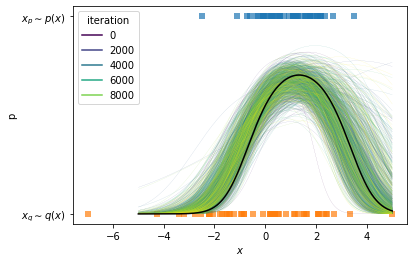

In [64]:
fig, ax = plt.subplots()

sns.lineplot(x="x", y="p", hue="iteration", units="iteration", estimator=None, 
             palette="mako", linewidth=0.1, alpha=0.7, data=data.query("iteration % 10 == 0"), ax=ax)

ax.scatter(X_p, np.ones_like(X_p), marker='s',
           edgecolors="none", alpha=0.7, zorder=2)
ax.scatter(X_q, np.zeros_like(X_q), marker='s',
           edgecolors="none", alpha=0.7, zorder=2)

ax.plot(X_grid, class_probability(X_grid), c='k', label=r"$\pi(x) = \sigma(f(x))$")

ax.set_yticks([0, 1])
ax.set_yticklabels([r"$x_q \sim q(x)$", r"$x_p \sim p(x)$"])
ax.set_xlabel('$x$')

plt.show()

In [45]:
frame = pd.DataFrame(data=np.vstack(omegas).T, index=X_train.squeeze(axis=-1))
frame.columns.name = "iteration"
frame.index.name = "x"

s = frame.stack()
s.name = "omega"

data = s.reset_index()
data

,x,iteration,omega
0,0.588780,0,0.051751
1,0.588780,1,0.099085
2,0.588780,2,0.096172
3,0.588780,3,0.175287
4,0.588780,4,0.131555
...,...,...,...
79995,1.658865,795,0.196582
79996,1.658865,796,0.063191
79997,1.658865,797,0.290562
79998,1.658865,798,0.106490


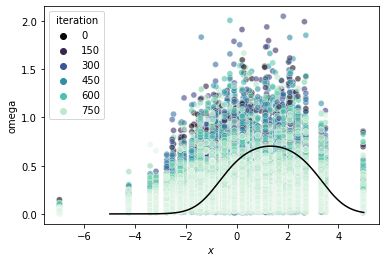

In [34]:
fig, ax = plt.subplots()

sns.scatterplot(x="x", y="omega", hue="iteration", palette="mako", 
                facecolor="none", alpha=0.6, data=data, ax=ax)

ax.plot(X_grid, class_probability(X_grid), c='k', label=r"$\pi(x) = \sigma(f(x))$")
ax.set_xlabel('$x$')

plt.show()

In [35]:
data = pd.DataFrame(data=np.vstack(betas), columns=map(r"$\beta_{{{:d}}}$".format, range(latent_dim)))
data.index.name = "iteration"
data.reset_index(inplace=True)

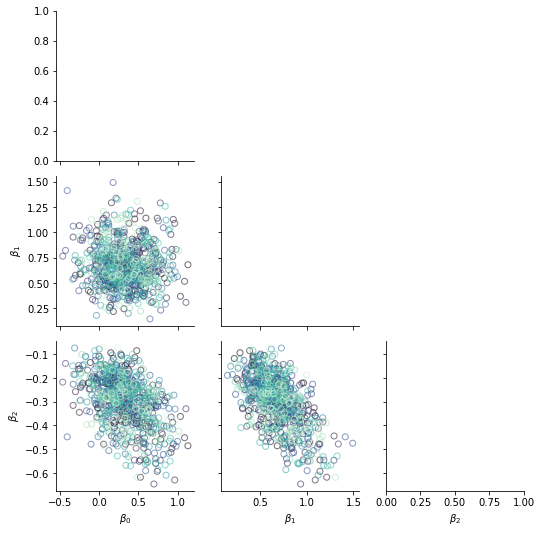

In [36]:
g = sns.PairGrid(data, hue="iteration", palette="mako", corner=True)
g = g.map_lower(plt.scatter, facecolor="none", alpha=0.6)